# 1. Insight Summary

## Loading libraries

In [1]:
import torch

print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.0.1+cpu
cpu


In [2]:
import os, sys, glob
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from sklearn.metrics import precision_score, recall_score
from transformers import BertForSequenceClassification, BertTokenizerFast, BertJapaneseTokenizer, Trainer, TrainingArguments
from transformers import pipeline, Pipeline
from datasets import load_dataset, Dataset

pd.options.display.float_format = "{:.4f}".format

## Preparing data

In [3]:
DATA_DIR = os.path.join(os.getcwd(), 'data\\STARS_4月')

In [4]:
# 店舗名が格納されたDataFrame
# 'store_code', 'store_name'
store_df_origin = pd.read_csv(os.path.join(DATA_DIR, 'store.csv'), encoding='cp932')
store_df = store_df_origin[['store_code', 'store_name']]
store_df = store_df.drop_duplicates()
print(store_df.shape)

# 回答の属性データ等
# 'answer_id', 'store_code', 'member_id', 'majica_no',
# 'majica_no_category', 'sex', 'age', 'occupation', 'create_datetime',
# 'sending_datetime', 'buying_amount'
answer_df_origin = pd.read_csv(os.path.join(DATA_DIR, 'answer.csv'), encoding='cp932')
answer_df = answer_df_origin[['answer_id', 'store_code', 'member_id', 'majica_no', 'majica_no_category', 'sex', 'age', 'occupation', 'create_datetime', 'sending_datetime', 'buying_amount']]
# answer_df = answer_df_origin[['answer_id', 'store_code']]
print(answer_df.shape)

# 回答データ
# 'question_answer_id', 'answer_id', 'question_id', 'answer_question'
qa_df = pd.read_csv(os.path.join(DATA_DIR, 'question_answer.csv'), encoding='cp932')
voc_df = qa_df[qa_df['answer_question'].notnull()][['question_answer_id', 'answer_id', 'question_id', 'answer_question']]
print(voc_df.shape)

(832, 2)
(3142615, 11)


C:\Users\000063JP6\AppData\Local\Temp\ipykernel_13900\3177550527.py:19: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  qa_df = pd.read_csv(os.path.join(DATA_DIR, 'question_answer.csv'), encoding='cp932')


(174035, 4)


In [5]:
# 結合
voc_all_df = pd.merge(
    left=pd.merge(left=voc_df, right=answer_df, on='answer_id'),
    right=store_df,
    on='store_code', 
    how='inner')

In [6]:
# 確認と保存、メモリ解放
assert voc_df.shape[0] == voc_all_df.shape[0], 'DataFrameのサイズが違います'

voc_all_df.to_csv(os.path.join(DATA_DIR, 'data.csv'), encoding='cp932', index=False)

del store_df_origin, store_df, answer_df_origin, answer_df, qa_df, voc_df, voc_all_df

### VoC

In [8]:
voc_all_df = pd.read_csv(
    os.path.join(DATA_DIR, 'data.csv'), encoding='cp932')

print(voc_all_df.columns)

voc_all_df = voc_all_df[['answer_question', 'store_name', 'buying_amount']]
print(voc_all_df.shape)

voc_all_df

Index(['question_answer_id', 'answer_id', 'question_id', 'answer_question',
       'store_code', 'member_id', 'majica_no', 'majica_no_category', 'sex',
       'age', 'occupation', 'create_datetime', 'sending_datetime',
       'buying_amount', 'store_name'],
      dtype='object')
(174035, 3)


,answer_question,store_name,buying_amount
0,品物豊富で何でもそろう！クーポンがあったり、大盛り肉が安くて助かる！幼児用の立つカートがあっ...,MEGAドン・キホーテ長野店,14025.0000
1,他店に比べて商品が多いので、欲しい商品を探すのも大変だが、ドンキは探すことも楽しさに繋がるの...,MEGAドン・キホーテ長野店,3695.0000
2,近い。,MEGAドン・キホーテ長野店,1620.0000
3,レジの時にクーポンのご利用はありますかと一言あると嬉しいです。,MEGAドン・キホーテ長野店,756.0000
4,ミニトマト、ハナノアが安いから。,MEGAドン・キホーテ長野店,753.0000
...,...,...,...
174030,他のドンキホーテも、あまり好きではない。物がごちゃごちゃして、先をみわたすことができず、目当...,MEGAドン・キホーテUNY大覚寺店,2835.0000
174031,ほしいのがあるので。,ドン・キホーテ セブンパークアリオ柏店,877.0000
174032,安い品が多いから！,ドン・キホーテ セブンパークアリオ柏店,877.0000
174033,いろんなコンタクトレンズあるから,ドン・キホーテ セブンパークアリオ柏店,3035.0000


### Store

In [10]:
store_list = voc_all_df['store_name'].unique()
len(store_list)

487

In [21]:
with open(os.path.join(DATA_DIR, 'store_list.txt'), mode='w', encoding='cp932') as f:
    f.write('\n'.join(store_list))

## EDA

In [24]:
voc_all_df.groupby('store_name')['answer_question'].count().sort_values(ascending=False)
# .to_csv(os.path.join(DATA_DIR, 'store_list.csv'))

store_name
MEGAドン・キホーテUNY東海通店        1763
MEGAドン・キホーテ大森山王店          1680
MEGAドン・キホーテ 福重店           1427
二俣川店                      1387
MEGAドン・キホーテUNY稲沢東店        1339
                          ... 
キラキラドンキ ダイバーシティ東京 プラザ店       4
ミチドンキ NEOPASA清水店             4
情熱職人東松山店                     2
お菓子ドンキ・お酒ドンキ店                2
情熱職人昭島店                      1
Name: answer_question, Length: 487, dtype: int64

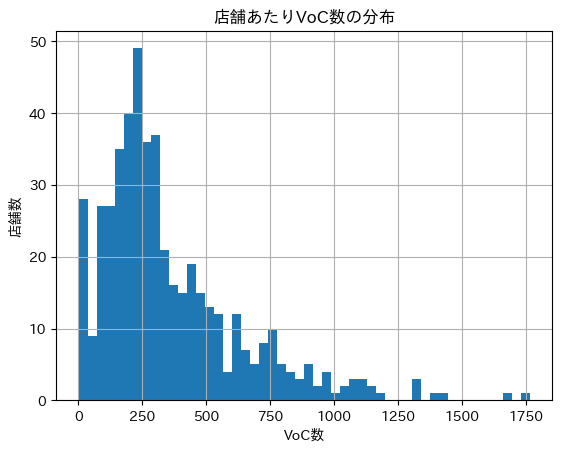

In [38]:
voc_all_df.groupby('store_name')['answer_question'].count().sort_values(ascending=False).hist(bins=50)
plt.title('店舗あたりVoC数の分布')
plt.xlabel('VoC数')
plt.ylabel('店舗数')
plt.show()

In [26]:
voc_all_df.groupby('store_name')['buying_amount'].sum().sort_values(ascending=False).astype(int)
# .to_csv(os.path.join(DATA_DIR, ''))

store_name
MEGAドン・キホーテUNY東海通店     7948933
MEGAドン・キホーテ大森山王店       6926261
MEGAドン・キホーテ 福重店        6691316
MEGAドン・キホーテ豊橋店         6351837
MEGAドン・キホーテUNY稲沢東店     5759663
                        ...   
情熱職人昭島店                  12360
ドン・キホーテ ららぽーと立川立飛店        8898
ドン・キホーテ セブンパークアリオ柏店       5649
ミチドンキ NEOPASA清水店          4692
お菓子ドンキ・お酒ドンキ店             1241
Name: buying_amount, Length: 487, dtype: int32

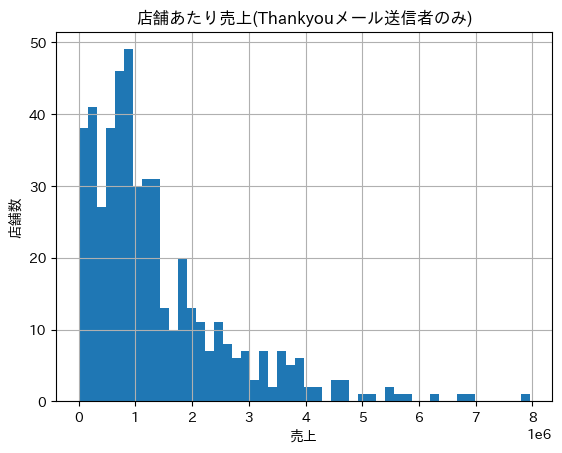

In [40]:
voc_all_df.groupby('store_name')['buying_amount'].sum().sort_values(ascending=False).astype(int).hist(bins=50)
plt.title('店舗あたり売上(Thankyouメール送信者のみ)')
plt.xlabel('売上')
plt.ylabel('店舗数')
plt.show()

## Inference

In [41]:
target_store_list = ['MEGAドン・キホーテUNY東海通店', 'MEGAドン・キホーテUNY 横浜大口店', 'ドン・キホーテ 川西店', 'ドン・キホーテ 六本木店','小樽店']
# MEGAドン・キホーテUNY東海通店: 1763
# MEGAドン・キホーテUNY 横浜大口店: 809
# 川西店: 304
# ドン・キホーテ 六本木店: 136
# 小樽店: 92

In [ ]:
from transformers import pipeline

tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-large-japanese-v2')
model = BertForSequenceClassification.from_pretrained('results_bert-base-japanese-v3_50', num_labels=3)
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)